In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00


In [1]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.14.0rc0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0

In [2]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import cv2
import matplotlib.pyplot as plt

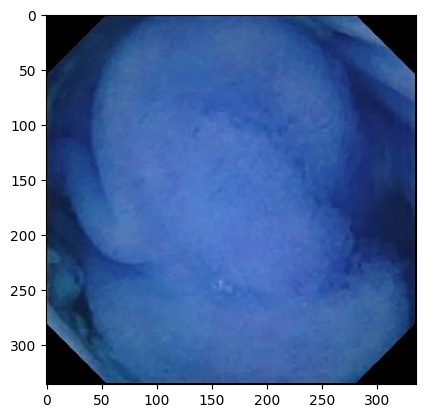

In [7]:
img = cv2.imread("/content/gdrive/MyDrive/Kvasir-Capsule-polyp-seg-Final/images/131368cc17e44240_28956.jpg")
plt.imshow(img,cmap='gray')

In [8]:
img.shape

(336, 336, 3)

In [9]:
import numpy as np
import glob

In [10]:
SIZE_X = 512
SIZE_Y = 512

In [11]:
train_images = []

for directory_path in glob.glob("/content/gdrive/MyDrive/Kvasir-Capsule-polyp-seg-Final/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_images = np.array(train_images).astype("uint8")

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/gdrive/MyDrive/Kvasir-Capsule-polyp-seg-Final/masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        # mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_masks = np.array(train_masks).astype("uint8")

In [12]:
X = train_images
Y = train_masks

In [13]:
X.shape

(55, 512, 512, 3)

In [14]:
Y.shape

(55, 512, 512)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [16]:
y_train.shape

(44, 512, 512)

In [17]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [18]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

print(model.summary())

85521592/85521592 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [19]:
history = model.fit(x_train,
          y_train,
          batch_size=8,
          epochs=10,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/10
6/6 [==============================] - 60s 3s/step - loss: -23.3005 - mse: 39206.7773 - val_loss: -763.2442 - val_mse: 39528.6055
Epoch 2/10
6/6 [==============================] - 3s 479ms/step - loss: -185.6175 - mse: 39144.7422 - val_loss: -28.1551 - val_mse: 39659.8086
Epoch 3/10
6/6 [==============================] - 3s 484ms/step - loss: -268.8467 - mse: 39120.6992 - val_loss: 927.6602 - val_mse: 39790.8086
Epoch 4/10
6/6 [==============================] - 3s 468ms/step - loss: -339.0659 - mse: 39110.0156 - val_loss: 82.3055 - val_mse: 39680.9531
Epoch 5/10
6/6 [==============================] - 3s 488ms/step - loss: -408.0244 - mse: 39097.8242 - val_loss: -846.2637 - val_mse: 39499.9961
Epoch 6/10
6/6 [==============================] - 3s 462ms/step - loss: -491.1217 - mse: 39089.0352 - val_loss: -1321.4766 - val_mse: 39488.1289
Epoch 7/10
6/6 [==============================] - 3s 486ms/step - loss: -575.1434 - mse: 39088.9023 - val_loss: -1818.6656 - val_mse: 39488.57

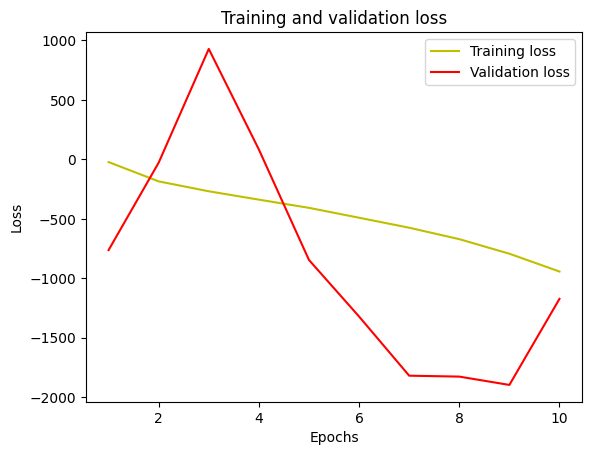

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
img_path = ("/content/gdrive/MyDrive/Kvasir-Capsule-polyp-seg-Final/images/131368cc17e44240_28955.jpg")
test_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (512, 512))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)
prediction_image = prediction.reshape((512,512))

1/1 [==============================] - 2s 2s/step


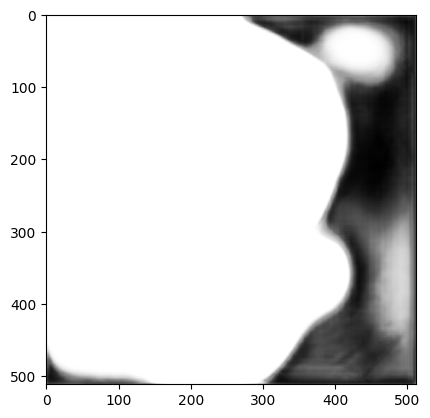

In [27]:
plt.imshow(prediction_image,cmap="gray")